In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CMAPSS
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CMAPSS
/content/drive/MyDrive/CMAPSS


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# ========== Load Data ==========

def load_data(train_path, test_path, rul_path):
    column_names = ['unit_number', 'time_in_cycles',
                    'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
                    [f'sensor_measurement_{i}' for i in range(1, 22)]

    train_df = pd.read_csv(train_path, sep=' ', header=None)
    train_df.drop(columns=[26, 27], inplace=True)
    train_df.columns = column_names

    test_df = pd.read_csv(test_path, sep=' ', header=None)
    test_df.drop(columns=[26, 27], inplace=True)
    test_df.columns = column_names

    rul_df = pd.read_csv(rul_path, header=None)

    return train_df, test_df, rul_df

In [4]:
# ========== Preprocess ==========

def compute_rul(train_df, test_df, rul_df):
    train_rul = train_df.groupby('unit_number')['time_in_cycles'].max()
    train_df['RUL'] = train_df.apply(lambda row: train_rul[row['unit_number']] - row['time_in_cycles'], axis=1)

    # For test set, get last cycle per unit
    test_rul = test_df.groupby('unit_number').last().reset_index()
    test_rul['RUL'] = rul_df.values

    return train_df, test_rul

In [5]:
def prepare_datasets(train_df, test_rul):
    sensor_cols = [col for col in train_df.columns if 'sensor_measurement' in col]
    drop_cols = ['unit_number','time_in_cycles','operational_setting_1','operational_setting_2','operational_setting_3']

    # Split train/val by engine ids
    engines = train_df['unit_number'].unique()
    train_ids, val_ids = train_test_split(engines, test_size=0.1, random_state=42)

    X_train = train_df[train_df['unit_number'].isin(train_ids)][sensor_cols]
    y_train = train_df[train_df['unit_number'].isin(train_ids)]['RUL']

    X_val = train_df[train_df['unit_number'].isin(val_ids)].groupby('unit_number').last()[sensor_cols]
    y_val = train_df[train_df['unit_number'].isin(val_ids)].groupby('unit_number').last()['RUL']

    X_test = test_rul[sensor_cols]
    y_test = test_rul['RUL']

    return X_train, y_train, X_val, y_val, X_test, y_test, sensor_cols

In [6]:
def scale_data(X_train, X_val, X_test):
    scaler = MinMaxScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)
    return X_train_s, X_val_s, X_test_s, scaler

In [7]:
# ========== Custom Linear Regression ==========

class Linear_Regression:
    def __init__(self, lr=0.01, iterations=150):
        self.lr = lr
        self.iterations = iterations

    def fit(self, X, Y):
        self.l, self.p = X.shape
        self.W = np.zeros(self.p)
        self.b = 0
        self.X = X
        self.Y = Y
        for _ in range(self.iterations):
            self._update_weights()
        return self

    def _update_weights(self):
        Y_pred = self.predict(self.X)
        dW = -2 * self.X.T.dot(self.Y - Y_pred) / self.l
        db = -2 * np.sum(self.Y - Y_pred) / self.l
        self.W -= self.lr * dW
        self.b -= self.lr * db

    def predict(self, X):
        return X.dot(self.W) + self.b

In [8]:
# ========== Evaluation ==========

def evaluate(y_true, y_pred, label=''):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"{label} → RMSE: {rmse:.3f}, MAE: {mae:.3f}")

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# (Other functions: load_data, compute_rul, prepare_datasets, scale_data, Linear_Regression, evaluate)

# ========== Exploratory Visualizations ==========
def exploratory_visualizations(train_df, sensor_cols, corr_threshold=0.8):
    # 1a) Engine lifetime distribution
    print("Plotting engine lifetime distribution → shows how many cycles engines typically run before failure.")
    lifetimes = train_df.groupby('unit_number')['time_in_cycles'].max()
    plt.figure(figsize=(6,4))
    sns.histplot(lifetimes, bins=30, kde=True)
    plt.title('Engine Lifetime Distribution'); plt.xlabel('Cycles'); plt.ylabel('Count')
    plt.grid(True); plt.show()

    # 1b) Sensor correlation heatmap
    print("Plotting sensor correlation heatmap → identifies highly correlated sensors (for possible feature reduction).")
    corr = train_df[sensor_cols].corr()
    # Print pairs above threshold
    high_corr = []
    for i in range(len(sensor_cols)):
        for j in range(i+1, len(sensor_cols)):
            if abs(corr.iloc[i,j]) >= corr_threshold:
                high_corr.append((sensor_cols[i], sensor_cols[j], corr.iloc[i,j]))
    if high_corr:
        print(f"Sensor pairs with |corr| ≥ {corr_threshold}: ")
        for s1, s2, val in high_corr:
            print(f"  {s1} ↔ {s2}: {val:.2f}")
    else:
        print(f"No sensor pairs exceed correlation threshold of {corr_threshold}.")

    plt.figure(figsize=(12,12))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
                xticklabels=sensor_cols, yticklabels=sensor_cols)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title('Sensor–Sensor Correlation Heatmap')
    plt.tight_layout(); plt.show()

    # 1c) Boxplots of sensor distributions (4 per figure)
    print("Plotting boxplots of each sensor (fliers hidden) → sees overall ranges and potential skew/outliers.")
    sensors_per_fig = 4
    for i in range(0, len(sensor_cols), sensors_per_fig):
        fig, axes = plt.subplots(2, 2, figsize=(8,6))
        axes = axes.flatten()
        for j in range(sensors_per_fig):
            idx = i + j
            if idx < len(sensor_cols):
                sensor = sensor_cols[idx]
                axes[j].boxplot(train_df[sensor], showfliers=False)
                axes[j].set_title(sensor)
                axes[j].grid(True)
            else:
                axes[j].axis('off')
        plt.tight_layout(); plt.show()

    # 1d) Sample sensor vs RUL curves (every 10th engine for all sensors)
    print("Plotting rolling-mean sensor behavior vs RUL for select engines → inspects degradation trends.")
    n_rows = int(np.ceil(len(sensor_cols) / 2))
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 3 * n_rows))
    axes = axes.flatten()
    for idx, sensor in enumerate(sensor_cols):
        for uid in train_df['unit_number'].unique():
            if uid % 10 == 0:
                sub = train_df[train_df['unit_number']==uid]
                axes[idx].plot(sub['RUL'], sub[sensor].rolling(10).mean(), alpha=0.6)
        axes[idx].set_xlim(250, 0)
        axes[idx].set_title(f'{sensor} vs RUL')
        axes[idx].set_xlabel('RUL')
        axes[idx].set_ylabel(sensor)
        axes[idx].grid(True)
    for j in range(len(sensor_cols), len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()


In [10]:
# ========== Predicted vs True Scatter‐Plots ==========

def plot_predicted_vs_true(y_true, y_pred, title):
    print(f"Scatter plot of predictions → how close points lie to the ideal y=x line.")
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.5)            # :contentReference[oaicite:1]{index=1}
    m = max(max(y_true), max(y_pred))
    plt.plot([0,m],[0,m], linestyle='--')            # ideal line
    plt.xlabel('True RUL'); plt.ylabel('Predicted RUL')
    plt.title(title)
    plt.tight_layout(); plt.show()

Plotting engine lifetime distribution → shows how many cycles engines typically run before failure.


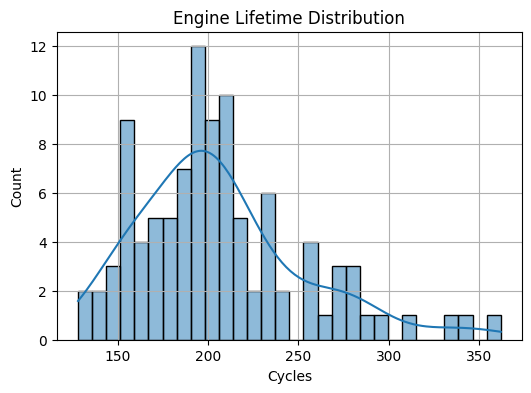

Plotting sensor correlation heatmap → identifies highly correlated sensors (for possible feature reduction).
Sensor pairs with |corr| ≥ 0.8: 
  sensor_measurement_4 ↔ sensor_measurement_11: 0.83
  sensor_measurement_4 ↔ sensor_measurement_12: -0.82
  sensor_measurement_7 ↔ sensor_measurement_11: -0.82
  sensor_measurement_7 ↔ sensor_measurement_12: 0.81
  sensor_measurement_8 ↔ sensor_measurement_13: 0.83
  sensor_measurement_9 ↔ sensor_measurement_14: 0.96
  sensor_measurement_11 ↔ sensor_measurement_12: -0.85


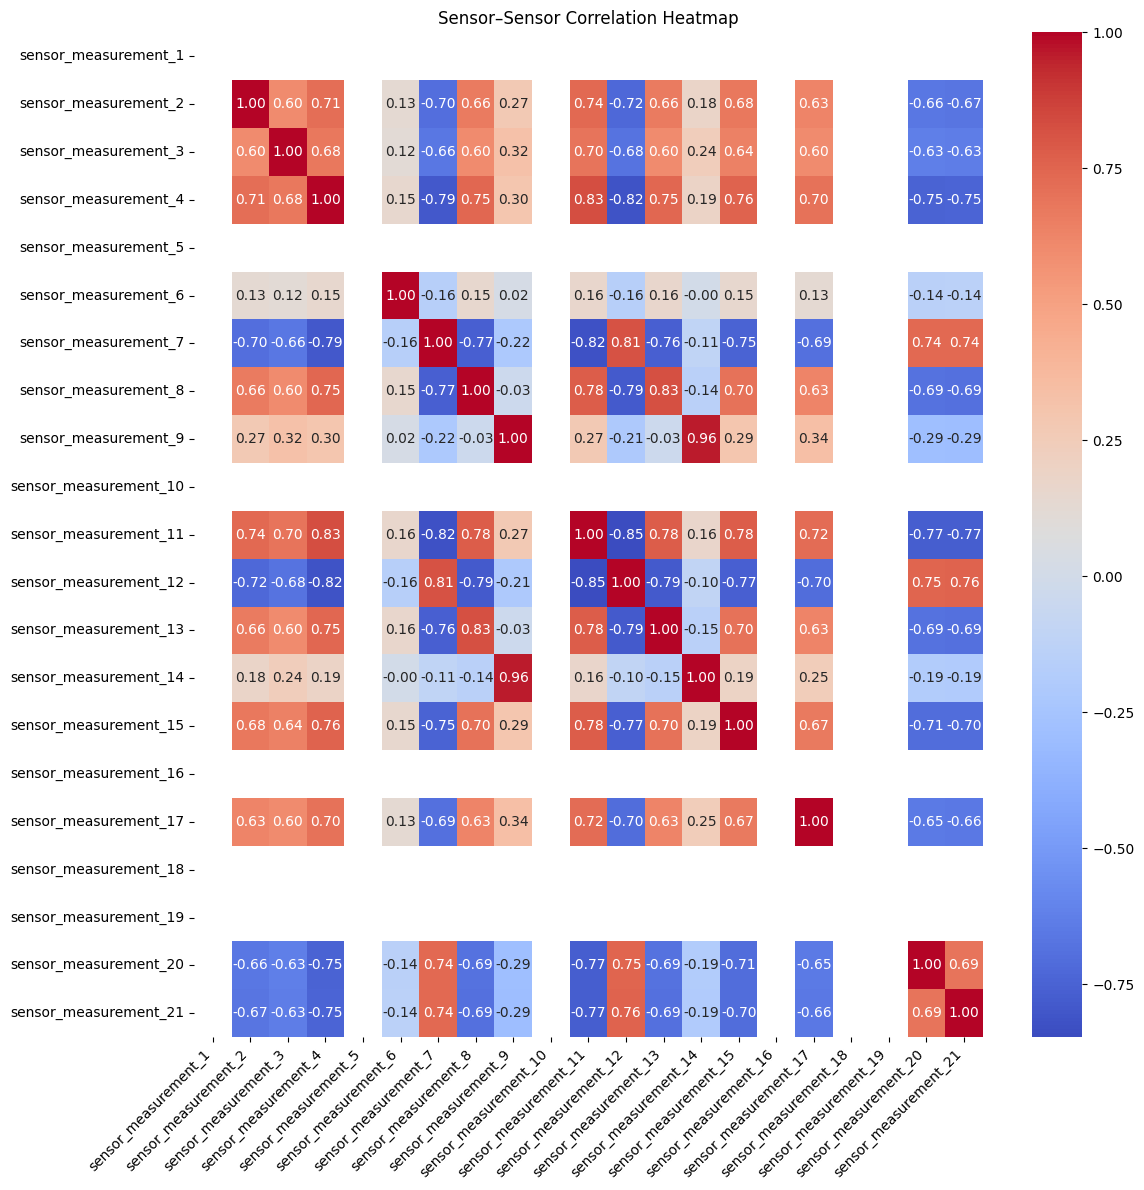

Plotting boxplots of each sensor (fliers hidden) → sees overall ranges and potential skew/outliers.


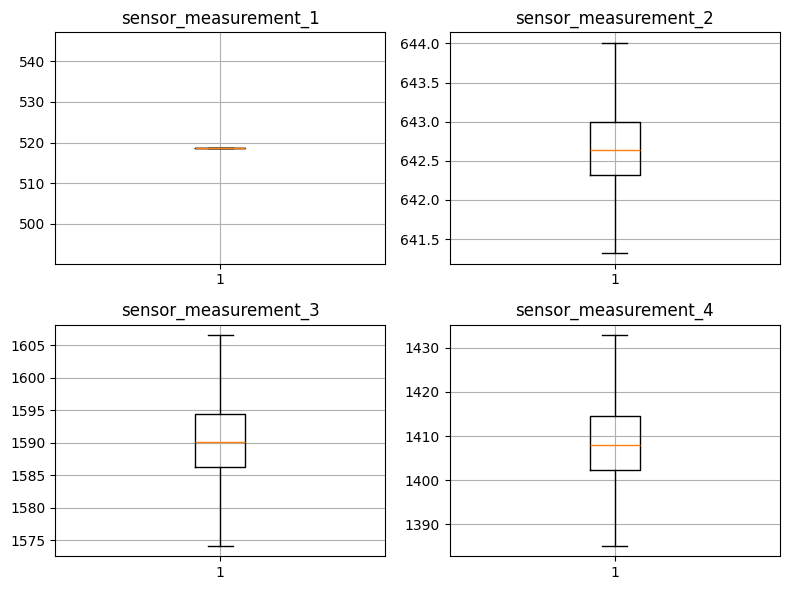

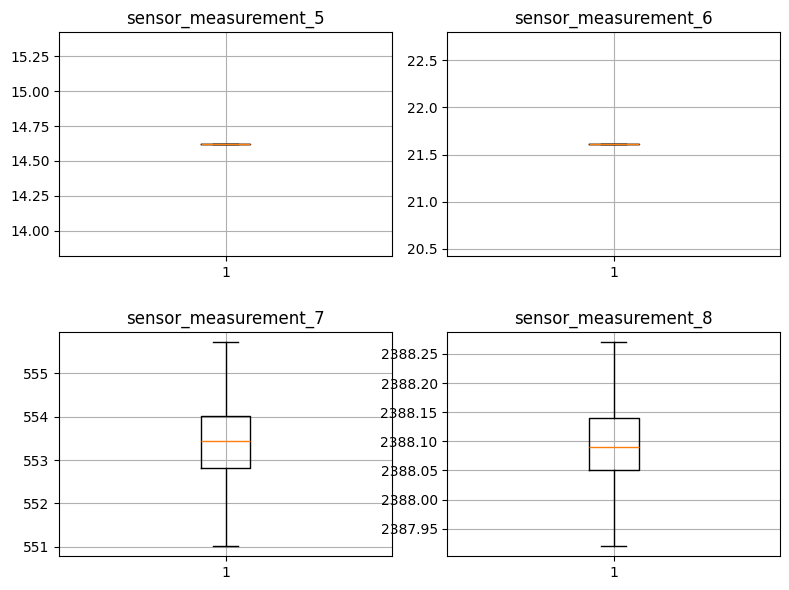

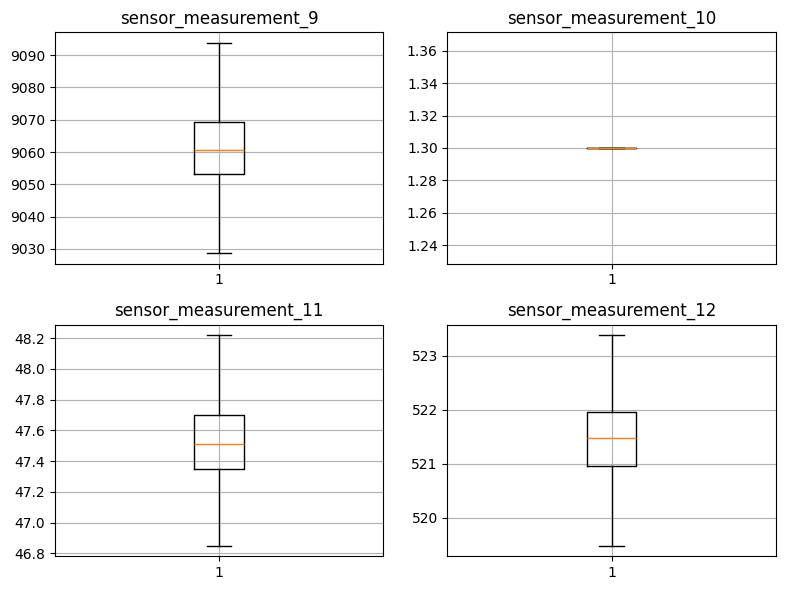

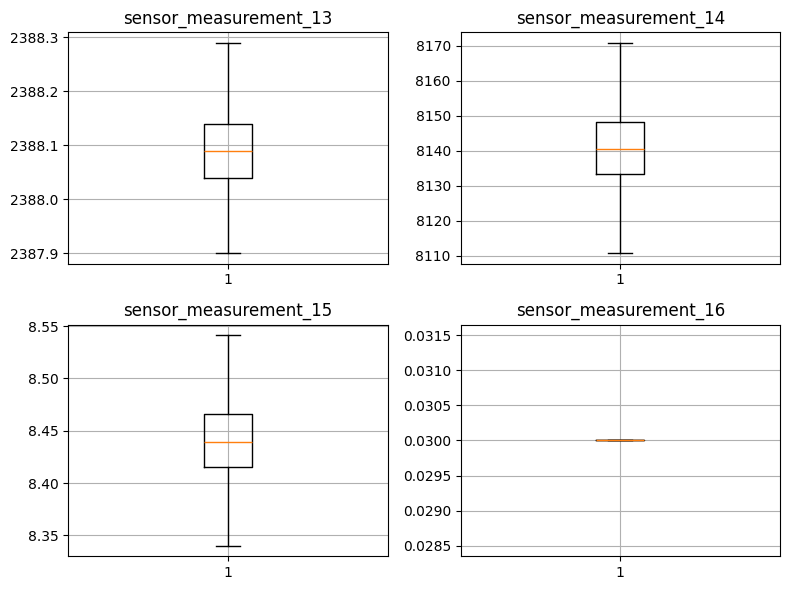

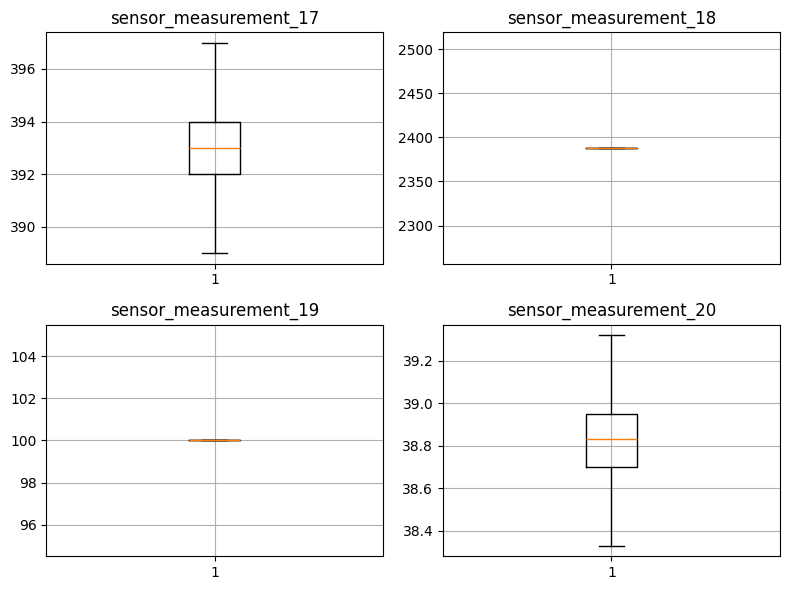

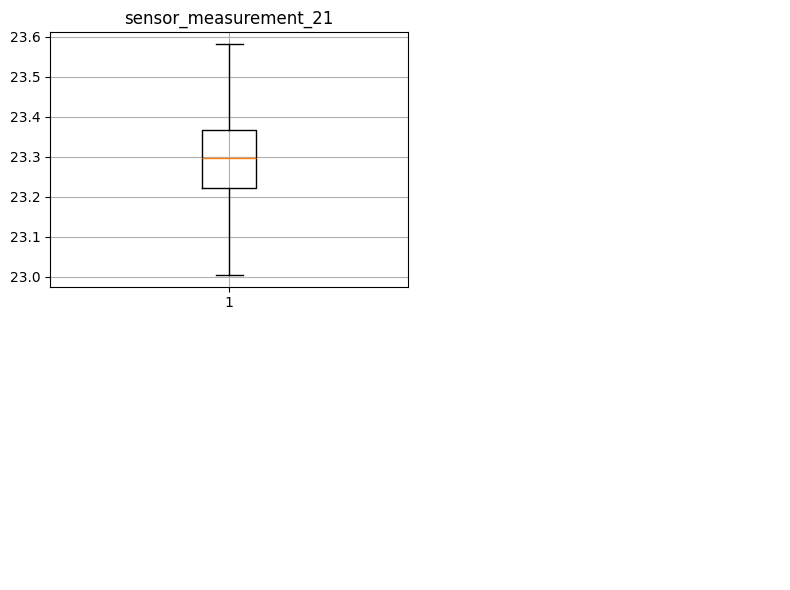

Plotting rolling-mean sensor behavior vs RUL for select engines → inspects degradation trends.


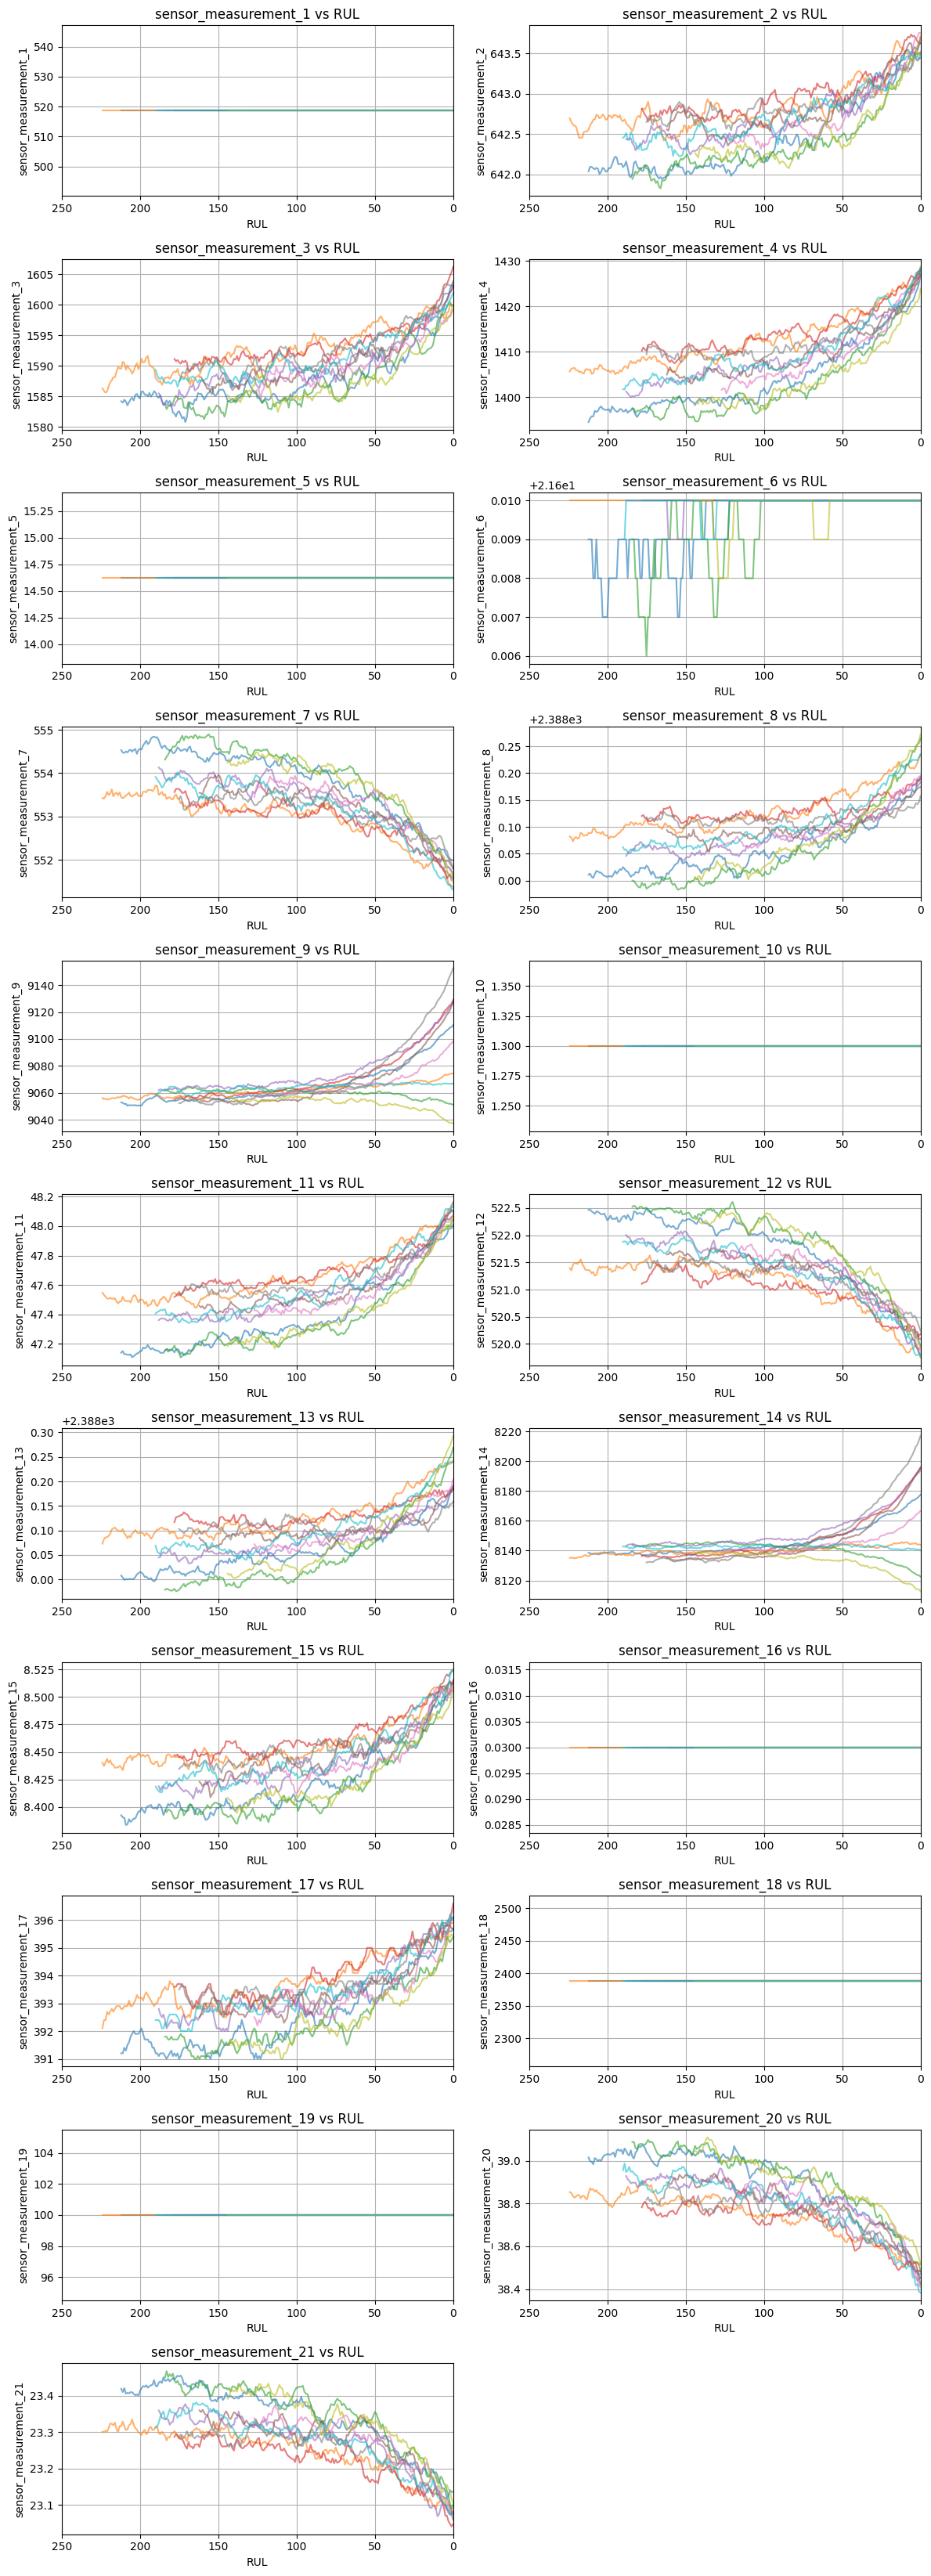


Training Custom Linear Regression...
Custom Train → RMSE: 47.310, MAE: 36.054
Custom Validation → RMSE: 8.578, MAE: 7.074
Custom Test → RMSE: 31.194, MAE: 25.485
Scatter plot of predictions → how close points lie to the ideal y=x line.


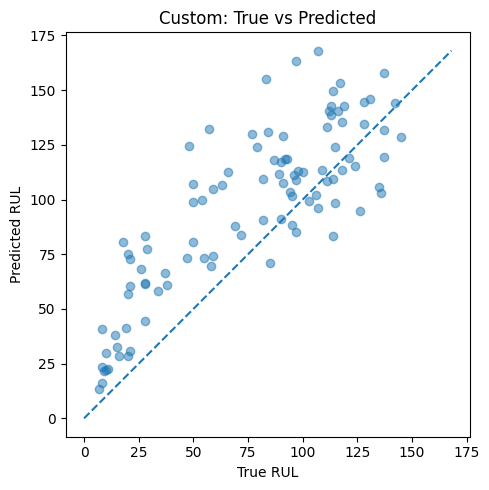


Training Sklearn Linear Regression...
Sklearn Train → RMSE: 44.924, MAE: 34.145
Sklearn Validation → RMSE: 42.065, MAE: 35.879
Sklearn Test → RMSE: 31.507, MAE: 25.030
Scatter plot of predictions → how close points lie to the ideal y=x line.


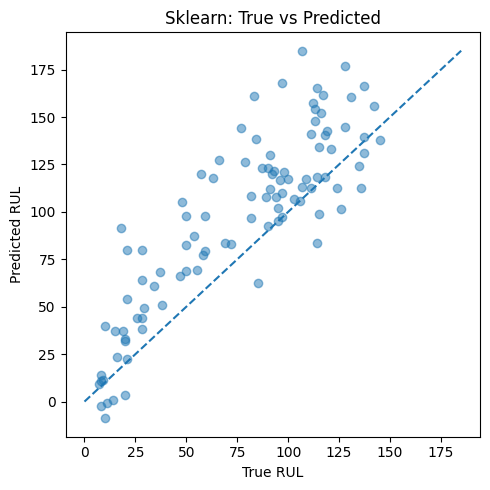

In [21]:
# ========== Main Pipeline ==========

def run_pipeline(train_path, test_path, rul_path):
    # Load + Preprocess
    train_df, test_df, rul_df = load_data(train_path, test_path, rul_path)
    train_df, test_rul = compute_rul(train_df, test_df, rul_df)
    sensor_cols = [c for c in train_df.columns if 'sensor' in c]

    # Visualizations
    exploratory_visualizations(train_df, sensor_cols)

    X_train, y_train, X_val, y_val, X_test, y_test, sensor_cols = prepare_datasets(train_df, test_rul)
    X_train_s, X_val_s, X_test_s, scaler = scale_data(X_train, X_val, X_test)

    # custom LR
    print("\nTraining Custom Linear Regression...")
    custom = Linear_Regression(lr=0.001, iterations=5000).fit(X_train_s, y_train.values)
    y_pred_train = custom.predict(X_train_s); evaluate(y_train, y_pred_train, 'Custom Train')
    y_pred_val   = custom.predict(X_val_s);   evaluate(y_val, y_pred_val, 'Custom Validation')
    y_pred_test  = custom.predict(X_test_s);  evaluate(y_test, y_pred_test, 'Custom Test')
    plot_predicted_vs_true(y_test, y_pred_test, 'Custom: True vs Predicted')

    # sklearn LR
    print("\nTraining Sklearn Linear Regression...")
    skl = SklearnLinearRegression().fit(X_train_s, y_train)
    y_pred_train2 = skl.predict(X_train_s); evaluate(y_train, y_pred_train2, 'Sklearn Train')
    y_pred_val2   = skl.predict(X_val_s);   evaluate(y_val, y_pred_val2, 'Sklearn Validation')
    y_pred_test2  = skl.predict(X_test_s);  evaluate(y_test, y_pred_test2, 'Sklearn Test')
    plot_predicted_vs_true(y_test, y_pred_test2, 'Sklearn: True vs Predicted')


# ========== Run ==========

run_pipeline(
    train_path='CMAPSSData/train_FD001.txt',
    test_path='CMAPSSData/test_FD001.txt',
    rul_path='CMAPSSData/RUL_FD001.txt'
)
